In [2]:
import pickle
import glob
import os
import numpy
import re
from collections import defaultdict
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
import networkx as nx
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from src.ZoneTransformer import zt

print(numpy.__version__)

2.2.6


In [3]:
# Path to your folder containing the .pkl files
folder_path = "./graphs"   # or "/absolute/path/to/graphs" if outside your project folder

graphs = []

# Loop through all .pkl files in the folder
for file in glob.glob(os.path.join(folder_path, "*.pkl")):
    with open(file, 'rb') as f:
        graphs.append(pickle.load(f))

print(f"Loaded {len(graphs)} graphs successfully!")


Loaded 112 graphs successfully!


In [4]:
folder_path = "./graphs"

# Dictionary: teamID → list of graphs
team_graphs = defaultdict(list)

# Regex pattern to extract teamID from filenames
pattern = re.compile(r"team(\d+)\.pkl")

for file in glob.glob(os.path.join(folder_path, "graph_match*_team*.pkl")):
    match = pattern.search(file)
    if match:
        team = int(match.group(1))  # convert to integer if needed
        with open(file, "rb") as f:
            graph = pickle.load(f)
        team_graphs[team].append(graph)

print(f"Loaded graphs for {len(team_graphs)} teams:")
for team, graphs in team_graphs.items():
    print(f"  Team {team}: {len(graphs)} graphs")

Loaded graphs for 3 teams:
  Team 1609: 38 graphs
  Team 1625: 37 graphs
  Team 1612: 37 graphs


In [5]:
# map team IDs to friendly names
team_name_map = {
    1609: "Arsenal",
    1612: "Liverpool",
    1625: "Manchester City",
}

# build new dictionary with readable team names
team_graphs_dict = {
    team_name_map[team_id]: graphs
    for team_id, graphs in team_graphs.items()
    if team_id in team_name_map
}

# Quick summary
for name, graphs in team_graphs_dict.items():
    print(f"{name}: {len(graphs)} graphs")

Arsenal: 38 graphs
Manchester City: 37 graphs
Liverpool: 37 graphs


In [6]:
# ===========================================
#  TEAM-LEVEL GCN AUTOENCODER FOR TACTICAL CLUSTERING
# ===========================================


# -----------------------------
# 1. Prepare each graph as PyG data
# -----------------------------
def prepare_pyg_data(G, zt=None, add_spatial=True):
    """
    Converts a zone transition graph into a PyTorch Geometric Data object.
    Includes node features + edge weights.
    """

    features = []
    for n in G.nodes():
        node = G.nodes[n]
        in_deg, out_deg = node["in_deg"], node["out_deg"]
        x_center, y_center = node["x_center"], node["y_center"]
        event_count = node["event_count"]
        unique_players = node["unique_players"]
        role_dist = node["role_distribution"]
        event_dist = node["event_distribution"]

        features.append(
            [
                x_center,
                y_center,
                in_deg,
                out_deg,
                event_count,
                unique_players,
                *role_dist,
                *event_dist,
            ]
        )

    X = torch.tensor(np.array(features, dtype=float), dtype=torch.float32)

    data = from_networkx(G)
    data.x = X

    # add edge weights as attributes
    edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
    data.edge_attr = torch.tensor(edge_weights, dtype=torch.float32)

    return data


# -----------------------------
# 2. Define the GCN Autoencoder
# -----------------------------
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, latent_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        z = self.conv2(x, edge_index, edge_weight=edge_weight)
        return z


class GraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super().__init__()
        self.encoder = GCNEncoder(in_channels, hidden_channels, latent_channels)

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index, data.edge_attr)
        # Adjacency reconstruction (inner product)
        adj_pred = torch.sigmoid(torch.mm(z, z.t()))
        return adj_pred, z


# -----------------------------
# 3. Train on all team graphs jointly
# -----------------------------
def train_team_autoencoder(
    team_graphs,
    zt=None,
    hidden_dim=16,
    latent_dim=3,
    epochs=200,
    lr=0.005,
    batch_size=1,
    device="cpu",
):
    # Prepare PyG data objects
    data_list = [prepare_pyg_data(G, zt) for G in team_graphs]
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

    # Model setup
    in_dim = data_list[0].x.shape[1]
    model = GraphAutoencoder(in_dim, hidden_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.train()
    for epoch in tqdm(range(epochs), desc="Training GCN Autoencoder"):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            A_pred, _ = model(data)

            # Ground-truth adjacency
            A_true = torch.zeros_like(A_pred)
            for i, (u, v) in enumerate(data.edge_index.t()):
                A_true[u, v] = 1.0

            loss = F.mse_loss(A_pred, A_true)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # if (epoch + 1) % 20 == 0:
        #     print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    return model


# -----------------------------
# 4. Extract embeddings for each match
# -----------------------------
def get_team_embeddings(model, team_graphs, zt=None, device="cpu"):
    model.eval()
    embeddings_per_match = []
    with torch.no_grad():
        for G in team_graphs:
            data = prepare_pyg_data(G, zt).to(device)
            _, z = model(data)
            # Instead of .numpy(), just keep as list
            embeddings_per_match.append(z.cpu().tolist())
    return embeddings_per_match

In [7]:
# Training models
if os.path.exists("models/GCN_model_team1609.pkl"):
    model_arsenal = pickle.load(open("models/GCN_model_team1609.pkl", "rb"))
else:
    model_arsenal = train_team_autoencoder(team_graphs_dict["Arsenal"], zt, epochs=200)
if os.path.exists("models/GCN_model_team1612.pkl"):
    model_liverpool = pickle.load(open("models/GCN_model_team1612.pkl", "rb"))
else:
    model_liverpool = train_team_autoencoder(
        team_graphs_dict["Liverpool"], zt, epochs=200
    )
if os.path.exists("models/GCN_model_team1625.pkl"):
    model_man_city = pickle.load(open("models/GCN_model_team1625.pkl", "rb"))
else:
    model_man_city = train_team_autoencoder(
        team_graphs_dict["Manchester City"], zt, epochs=200
    )

In [ ]:
# save models to disk
# with open("model_teamA.pkl", "wb") as f:
#     pickle.dump(model_A, f)
# with open("model_teamB.pkl", "wb") as f:
#     pickle.dump(model_B, f)
# with open("model_teamC.pkl", "wb") as f:
#     pickle.dump(model_C, f)

In [16]:
def kmeans_torch(X, n_clusters=3, n_iters=100, verbose=False):
    """
    Simple KMeans clustering in PyTorch
    X: tensor of shape (n_samples, n_features)
    Returns: cluster assignments, centroids
    """
    n_samples, n_features = X.shape

    # Initialize centroids randomly from data points
    indices = torch.randperm(n_samples)[:n_clusters]
    centroids = X[indices]

    for i in range(n_iters):
        # Compute distances (squared Euclidean)
        dists = torch.cdist(X, centroids, p=2)  # (n_samples, n_clusters)
        # Assign clusters
        cluster_ids = torch.argmin(dists, dim=1)
        # Update centroids
        new_centroids = torch.stack([
            X[cluster_ids == k].mean(dim=0) if (cluster_ids == k).sum() > 0 else centroids[k]
            for k in range(n_clusters)
        ])
        # Check for convergence
        if torch.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
        if verbose:
            print(f"Iteration {i+1} done")
    return cluster_ids, centroids


In [17]:
# Example: get embeddings from trained autoencoders
emb_arsenal = get_team_embeddings(model_arsenal, team_graphs_dict["Arsenal"], zt)
emb_liverpool = get_team_embeddings(model_liverpool, team_graphs_dict["Liverpool"], zt)
emb_man_city = get_team_embeddings(
    model_man_city, team_graphs_dict["Manchester City"], zt
)

In [18]:
# Convert your embeddings to a tensor
tensor_emb_arsenal = torch.tensor(
    [item for match in emb_arsenal for item in match], dtype=torch.float32
)
tensor_emb_liverpool = torch.tensor(
    [item for match in emb_liverpool for item in match], dtype=torch.float32
)
tensor_emb_man_city = torch.tensor(
    [item for match in emb_man_city for item in match], dtype=torch.float32
)

In [19]:
clusters_arsenal, centroids_arsenal = kmeans_torch(tensor_emb_arsenal, n_clusters=5)
clusters_liverpool, centroids_liverpool = kmeans_torch(
    tensor_emb_liverpool, n_clusters=5
)
clusters_man_city, centroids_man_city = kmeans_torch(tensor_emb_man_city, n_clusters=5)

In [14]:
def visualize_clusters(
    G, labels, zt=None, figsize=(12, 8), title="Deep Zone Clustering"
):
    """
    G: NetworkX graph
    labels: 1D array of cluster IDs per node
    zt: optional object with get_zone_center(node)
    """
    plt.figure(figsize=figsize)

    if zt is not None and hasattr(zt, "get_zone_center"):
        pos = {n: zt.get_zone_center(n) for n in G.nodes()}
    else:
        pos = nx.spring_layout(G, seed=42)

    labels = np.array(labels)
    colors = plt.cm.tab10(labels.astype(int) % 10)

    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=800, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(title)
    plt.axis("off")
    plt.show()

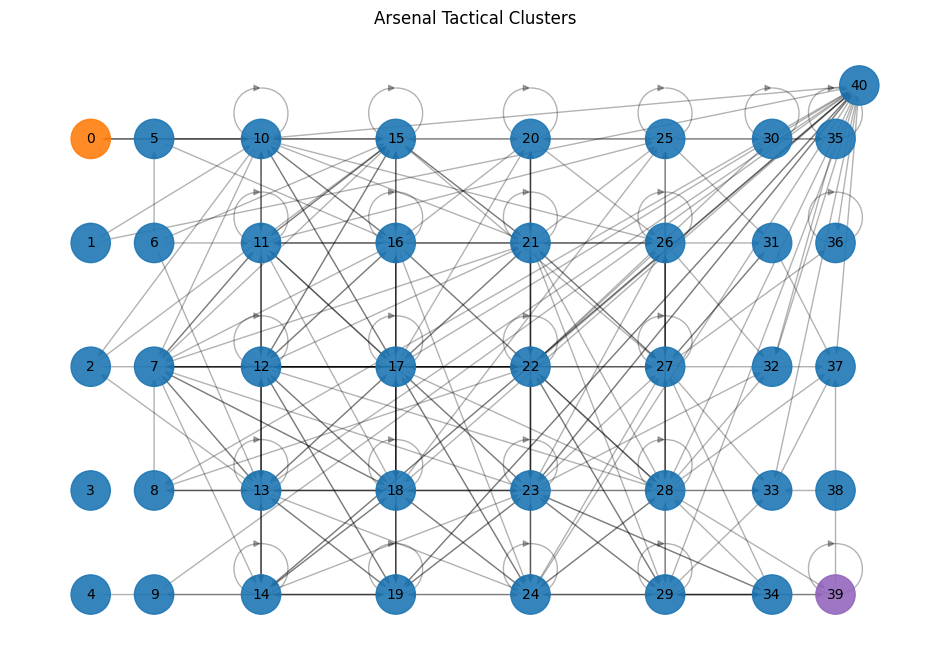

In [22]:
match_id = 10  # first match

visualize_clusters(
    team_graphs_dict["Arsenal"][match_id],
    clusters_arsenal.numpy()[: len(team_graphs_dict["Arsenal"][match_id].nodes())],
    zt,
    title="Arsenal Tactical Clusters",
)

In [122]:
class EncoderWrapper(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, x, edge_index, **kwargs):
        # ignore extra args
        return self.encoder(x, edge_index)

In [ ]:
import torch
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
from torch_geometric.utils import from_networkx


def explain_team_autoencoder(
    model, team_graph, zt=None, device="cpu", node_id=None, epochs=200
):
    """
    Run GNNExplainer on a trained team-level GCN Autoencoder model.

    Args:
        model: trained GraphAutoencoder instance
        team_graph: one NetworkX graph (team-match graph)
        zt: ZoneTransformer (optional, adds spatial info)
        device: 'cpu' or 'cuda'
        node_id: int, zone ID to explain (default = most central zone)
        epochs: number of explainer optimization steps
    """
    data = from_networkx(team_graph)
    data = prepare_pyg_data(team_graph, zt).to(device)

    # pick a node to explain
    if node_id is None:
        node_id = 0

    model_config = ModelConfig(
        mode="regression",  # GAE reconstructs continuous adjacency strengths
        task_level="node",  # we explain node embeddings
        return_type="raw",  # GAE outputs continuous embeddings
    )

    explainer = Explainer(
        model=EncoderWrapper(
            model.encoder
        ),  # only the encoder part produces embeddings
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type="model",  # we explain the model behavior, not a specific label
        node_mask_type="attributes",
        edge_mask_type="object",
        model_config=model_config,
    )

    explanation = explainer(x=data.x, edge_index=data.edge_index, node_index=node_id)

    # print(f"Explained zone {node_id} ({zt.get_zone_name(node_id) if zt else node_id})")
    # print(f"Available explanations: {explanation.available_explanations}")

    return explanation

In [142]:
feat_labels = [
    "x_center",
    "y_center",
    "in_deg",
    "out_deg",
    "event_count",
    "unique_players",
    "role_GK",
    "role_DEF",
    "role_MID",
    "role_FWD",
    "event_pass",
    "event_shot",
    "event_duel",
    "event_goalkeeper",
]

In [143]:
G_example_arsenal = team_graphs_dict["Arsenal"][0]
G_example_liverpool = team_graphs_dict["Liverpool"][0]
G_example_man_city = team_graphs_dict["Manchester City"][0]

explanation_example_arsenal = explain_team_autoencoder(
    model_arsenal, G_example_arsenal, zt, node_id=14
)
explanation_example_liverpool = explain_team_autoencoder(
    model_liverpool, G_example_liverpool, zt, node_id=14
)
explanation_example_man_city = explain_team_autoencoder(
    model_man_city, G_example_man_city, zt, node_id=14
)

In [149]:
feat_importance_arsenal = (
    explanation_example_arsenal.node_mask.detach().cpu().numpy().mean(axis=0)
)
print("Feature importance:")
for feat, val in zip(feat_labels, feat_importance_arsenal):
    print(f"  Feature {feat}: {val:.3f}")

Feature importance:
  Feature x_center: 0.283
  Feature y_center: 0.400
  Feature in_deg: 0.225
  Feature out_deg: 0.254
  Feature event_count: 0.355
  Feature unique_players: 0.186
  Feature role_GK: 0.024
  Feature role_DEF: 0.127
  Feature role_MID: 0.127
  Feature role_FWD: 0.100
  Feature event_pass: 0.149
  Feature event_shot: 0.043
  Feature event_duel: 0.000
  Feature event_goalkeeper: 0.000


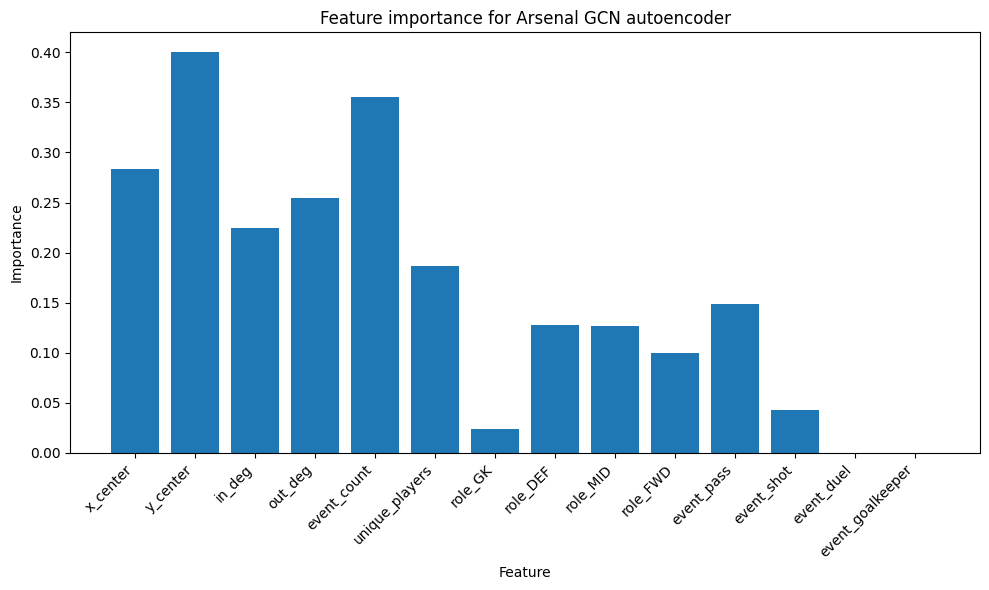

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(feat_importance_arsenal)), feat_importance_arsenal)
plt.xticks(range(len(feat_labels)), feat_labels, rotation=45, ha="right")
plt.title("Feature importance for Arsenal GCN Autoencoder")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

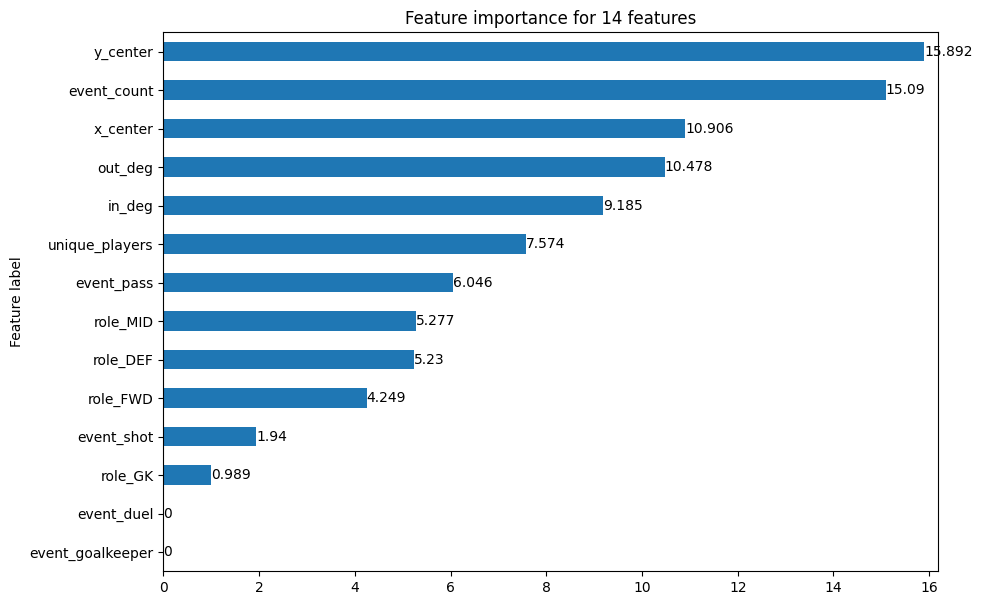

In [ ]:
explanation_example_arsenal.visualize_feature_importance(feat_labels=feat_labels)

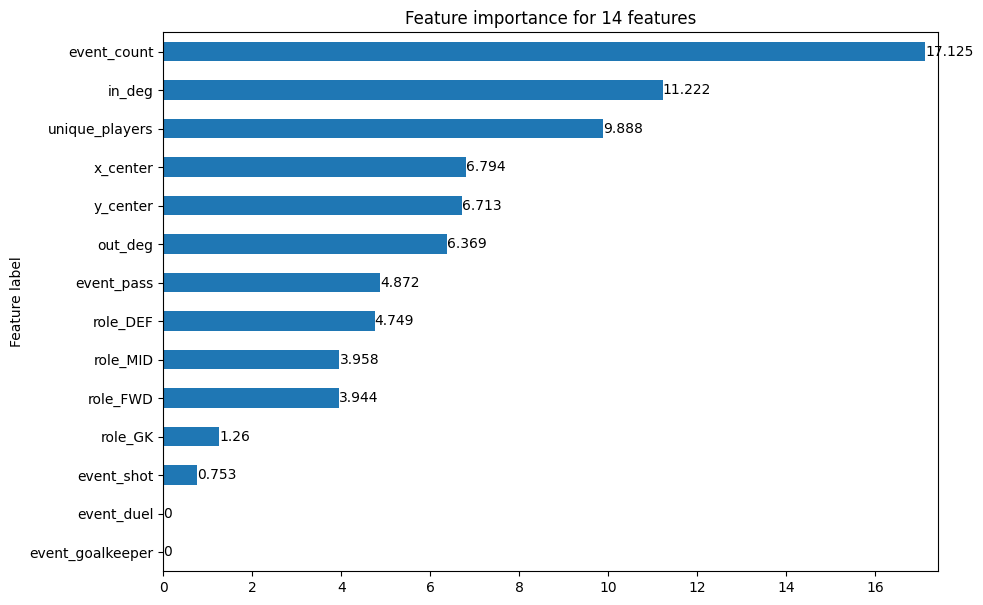

In [139]:
explanation_example_liverpool.visualize_feature_importance(feat_labels=feat_labels)

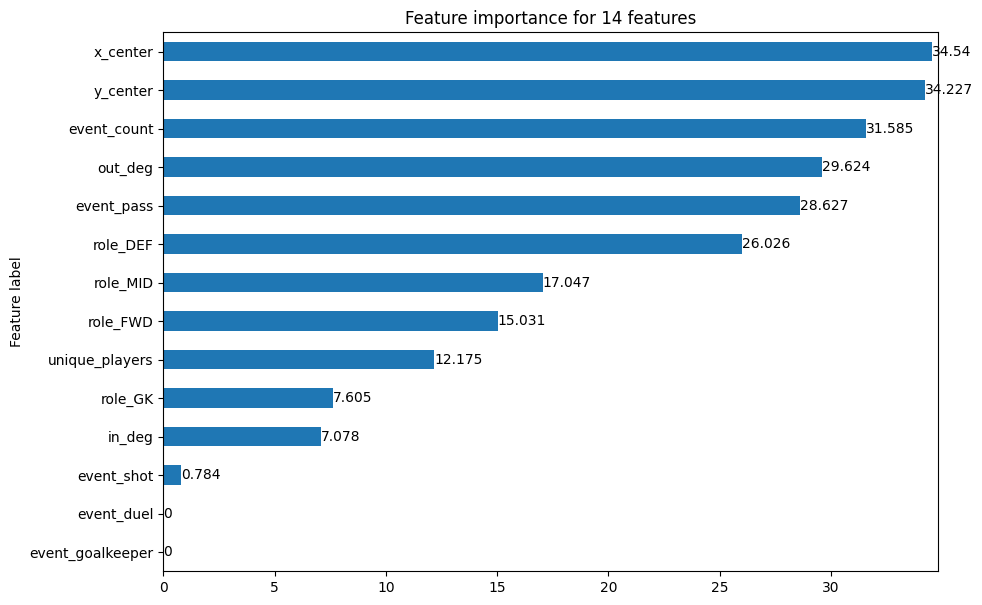

In [140]:
explanation_example_man_city.visualize_feature_importance(feat_labels=feat_labels)

In [173]:
def global_feature_importance(model, team, zt, device="cpu", sample_zones=range(40)):
    all_masks = []
    for G in tqdm(
        team_graphs_dict[team],
        desc=f"Computing global feature importance for {team}",
        position=tqdm._get_free_pos(),
    ):
        for node_id in tqdm(
            sample_zones,
            desc="Zones",
            position=tqdm._get_free_pos(),
            leave=False,
        ):
            try:
                exp = explain_team_autoencoder(
                    model, G, zt, device=device, node_id=node_id, epochs=100
                )
                all_masks.append(exp.node_mask.detach().cpu().numpy().mean(axis=0))
            except Exception:
                continue

    all_masks = np.array(all_masks)
    return all_masks

In [ ]:
global_all_masks_arsenal = global_feature_importance(model_arsenal, "Arsenal", zt)

Computing global feature importance for Arsenal:   0%|          | 0/38 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

In [182]:
global_all_masks_arsenal.shape

(1520, 14)

In [181]:
global_importance_arsenal = global_all_masks_arsenal.mean(axis=0)
global_importance_arsenal.shape

(14,)

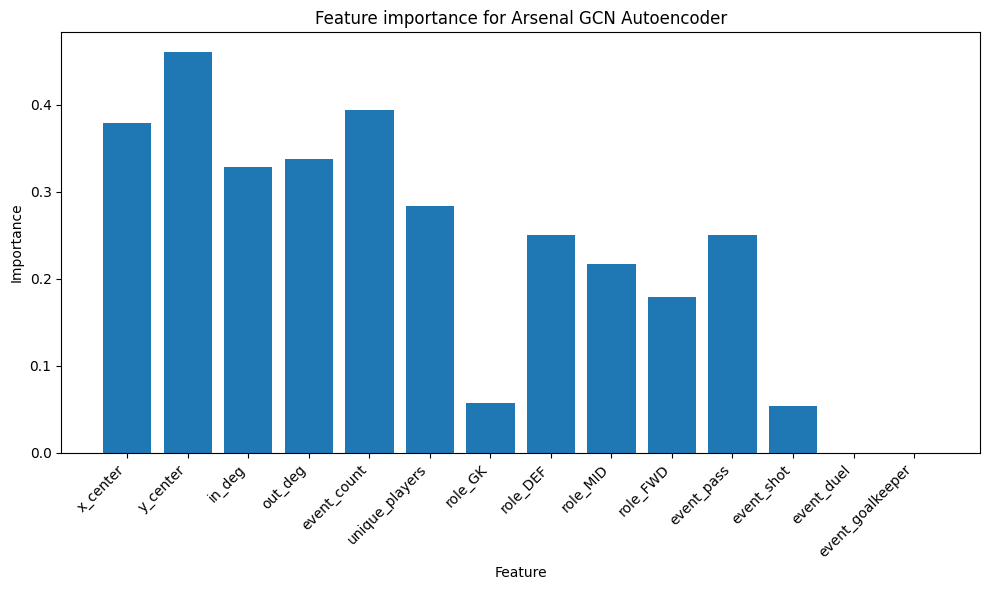

In [180]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(global_importance_arsenal)), global_importance_arsenal)
plt.xticks(range(len(feat_labels)), feat_labels, rotation=45, ha="right")
plt.title("Feature importance for Arsenal GCN Autoencoder")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()